In [1]:
import numpy as np

This notebook is focused on changing from programing from an element-wise approach to a vectorized approach, which is more efficient and faster when using NumPy.

The two easiest ways to optimize your code is to avoid (`for`, `while`, ...) loops and `if` statements when handling NumPy arrays. Instead, you should use vectorized operations.

# Getting rid of if statements

If statements are not vectorized, so they are not efficient when working with NumPy arrays. Let's see an example of how to get rid of if statements.

In [2]:
a = np.random.randn(10)
print(f"a: {a}")

# What if we want to set all negative values to 0?
b = np.empty_like(a)
for i in range(len(a)):
    if a[i] < 0:
        b[i] = 0
    else:
        b[i] = a[i]

# Apply element-wise maximum between a and 0 (usses broadcasting)
c = np.maximum(a, 0)  # This is much faster and more readable

# Masking
d = a.copy()
d[d < 0] = 0

# Masking with boolean array
e = a.copy()
mask = a < 0
e[mask] = 0

print(np.all(b == c) and np.all(c == d) and np.all(d == e))

a: [-0.18214196 -0.08948086 -1.7331061   0.7455456  -0.87501252  1.28083243
  1.7809662   2.70785522  0.39878326 -1.09913574]
True


Let's say we know how to write the element-wise version of what we want to do, which is the below `elementwise_func` function. How can we change it to a vectorized version?

In [3]:
def elementwise_func(x):
    if x > 1:
        return np.log(x) + 1
    elif x > -1:
        return np.sign(x) * np.sqrt(np.abs(x))
    else:
        return - x**2

If you're a visual learner/thinker, we can also plot this function to see what it does.

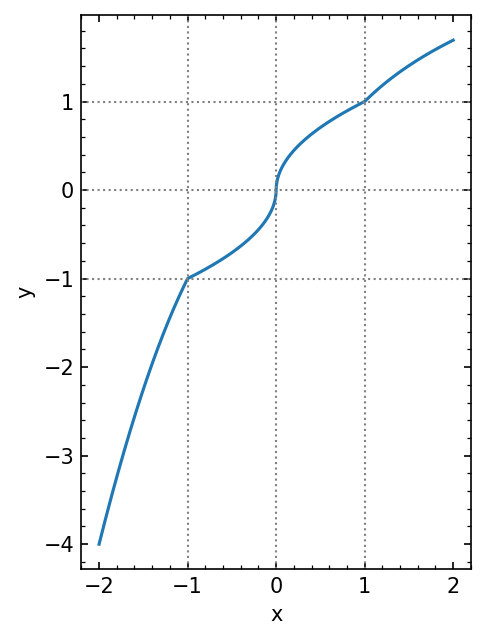

In [4]:
# Import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-2, 2, 1000)
# Apply the function elementwise (not vectorized)
y = np.array([elementwise_func(xi) for xi in x])

# Plot the function
plt.figure(dpi=150)  # Set the resolution of the figure
plt.subplot(aspect="equal")  # Set the aspect ratio of the plot to be equal
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
# Add guidelines at branches
for i in [-1, 0, 1]:
    plt.axvline(i, color="0.5", linestyle=":", linewidth=1)
    plt.axhline(i, color="0.5", linestyle=":", linewidth=1)

# These are my personal preferences for plots/ticks
ax = plt.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='both', direction='in')


This below approach is _so_ slow... How slow is it?

In [5]:
a = np.random.randn(1_000, 1_000)

def slow_func(arr):
    """
    This is a slow way to apply elementwise_func to all elements of arr
    """
    try:
        assert arr.ndim == 2
    except AssertionError:
        raise ValueError("Input array must be 2D")
    b = np.empty_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            b[i,j] = elementwise_func(arr[i,j])
    return b

%timeit slow_func(a)

939 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Just vectorize it bro
vfunc = np.vectorize(elementwise_func)
%timeit vfunc(a)

936 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


...slight improvement

### Exercise 1

Make a vectorized version of the below function `elementwise_func` using NumPy. Use the cell below and keep the `def fast_func(arr):` signature.

In [7]:
def fast_func(arr):
    # Write a vectorized version of elementwise_func
    # Replace this with your code. This is just a placeholder.
    return slow_func(arr)  # This is wrong

Test your function with the below cell.

In [8]:
# Compute both slow and fast versions
slow, fast = slow_func(a), fast_func(a)
# Compare the results
err = np.abs(slow - fast)
# Find the maximum relative error and its location
loc = np.unravel_index(np.argmax(err), err.shape)  # convert flat index to 2D index
rel_err_max = np.max(err) / np.abs(slow[loc])

# Print the results
print("Slow and fast are (roughly) equal:", np.allclose(slow, fast))
print(f"Maximum relative error: {rel_err_max:.03g}, at location: ({loc[0]}, {loc[1]})")
print("\nAt this location:")
print("    a[loc]    =", a[loc])
print("    slow[loc] =", slow[loc])
print("    fast[loc] =", fast[loc])

# Asside: Why is there a difference? (hint: machine precision)
#         This could be a whole lecture on its own, and it has been:
#         https://researchcomputing.princeton.edu/events/2025/floating-point-numbers-arent-real
print("\nMachinemachine precision:",
      np.finfo(np.float64).epsneg,
      np.finfo(np.float64).eps)

Slow and fast are (roughly) equal: True
Maximum relative error: 0, at location: (0, 0)

At this location:
    a[loc]    = 1.0009107613779993
    slow[loc] = 1.0009103468865048
    fast[loc] = 1.0009103468865048

Machinemachine precision: 1.1102230246251565e-16 2.220446049250313e-16


How fast is your fast_func?


In [9]:
%timeit fast_func(a)

979 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compare the runtimes of the functions. We'll also time my solution here. Can you beat me?

In [10]:
from instructor_solutions.solutions_05 import exercise_1

print("slow_func:")
%timeit slow_func(a)
print("\nfast_func:")
%timeit fast_func(a)
print("\ninstructor:")
%timeit exercise_1(a)

slow_func:
1.06 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

fast_func:
953 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

instructor:
22.6 ms ± 421 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Exercise 2

Compute distances between all points in `X` and `Y`. An element-wise version of this function is given below. Can you make a vectorized version of it?

In [11]:
points = np.random.rand(1000, 2)  # 1000 points in 2D


def slow_dist_matrix(points):
    """
    Input: points is an Nx2 array of points in 2D
    Output: NxN array of distances between points
            out[i, j] = distance between points[i,:] and points[j,:]
    """
    N = len(points)
    distances = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = np.sqrt((points[i, 0] - points[j, 0]) ** 2
                                      + (points[i, 1] - points[j, 1]) ** 2)
    return distances

distances = slow_dist_matrix(points)

In [12]:
def fast_dist_matrix(points):
    # Write a vectorized version of slow_dist_matrix
    # Replace this with your code. This is just a placeholder.
    return slow_dist_matrix(points)  # This is wrong

In [13]:
# Compute both slow and fast versions
slow, fast = slow_dist_matrix(points), fast_dist_matrix(points)
# Compare the results
err = np.abs(slow - fast)
# Find the maximum relative error and its location
loc = np.unravel_index(np.argmax(err), err.shape)  # convert flat index to 2D index
rel_err_max = np.max(err) / np.abs(slow[loc])

# Print the results
print("Slow and fast are (roughly) equal:", np.allclose(slow, fast))
print(f"Maximum relative error: {rel_err_max:.03g}, at location: ({loc[0]}, {loc[1]})")
print("\nAt this location:")
print("    points =", points[loc[0], :], points[loc[1], :])
print("    slow   =", slow[loc])
print("    fast   =", fast[loc])

Slow and fast are (roughly) equal: True
Maximum relative error: nan, at location: (0, 0)

At this location:
    points = [0.36644026 0.55833291] [0.36644026 0.55833291]
    slow   = 0.0
    fast   = 0.0


/var/folders/xc/xqgmw3710dv2n83qk5mrr1xm0000gn/T/ipykernel_86377/4032035900.py:7: RuntimeWarning: invalid value encountered in scalar divide
  rel_err_max = np.max(err) / np.abs(slow[loc])


In [14]:
from instructor_solutions.solutions_05 import exercise_2

print("slow_func:")
%timeit slow_dist_matrix(points)
print("\nfast_func:")
%timeit fast_dist_matrix(points)
print("\ninstructor:")
%timeit exercise_2(points)

slow_func:
767 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

fast_func:
770 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

instructor:
2.8 ms ± 246 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Choosing What to Optimize (Profiling)

I.e. optimizing what you should optimize.

When optimizing code, you should always choose the most time-consuming part of your code to optimize. Don't waste time optimizing code that takes a negligible amount of time. Sometimes removing for loops can take a lot of time/effort and not give you much in return.